In [ ]:
!pip install --upgrade pyDOE

In [ ]:
import numpy as np   
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
class BayesianLinearRegression:
  """
    Linear regression model: y = (w.T)*x + \epsilon
    w ~ N(0,beta^(-1)I)
    P(y|x,w) ~ N(y|(w.T)*x, alpha^(-1)I)
  """
  def __init__(self, X, y, alpha = 1.0, beta = 1.0):
      # Store training data
      self.X = X
      self.y = y
      # Store precisions
      self.alpha = alpha
      self.beta = beta
      # Small jitter for numerically stable matrix inversion
      self.jitter = 1e-8

  # Computes the MLE estimate of the regression weights
  def fit_MLE(self):
      xTx_inv = np.linalg.inv(np.matmul(self.X.T,self.X) + self.jitter*np.eye(self.X.shape[1]))
      xTy = np.matmul(self.X.T, self.y)
      w_MLE = np.matmul(xTx_inv, xTy)
      self.w_MLE = w_MLE
      return w_MLE

  # Computes the MAP estimate of the regression weights
  def fit_MAP(self):
      Lambda = np.matmul(self.X.T,self.X) + \
               (self.beta/self.alpha)*np.eye(self.X.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      xTy = np.matmul(self.X.T, self.y)
      mu = np.matmul(Lambda_inv, xTy)
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      return mu, Lambda_inv

  # Computes the predictive posterior distribution
  def predictive_distribution(self, X_star):
      mean_star = np.matmul(X_star, self.w_MAP)
      var_star = np.eye(X_star.shape[1])/self.alpha + \
                 np.matmul(X_star, np.matmul(self.Lambda_inv, X_star.T))
      return mean_star, var_star


In [ ]:
# N is the number of training points.
N = 50
noise_var = 0.2
alpha = 1.0/noise_var
beta = 0.2

In [ ]:
# Create random input and output data
X = np.random.rand(N,1)
y = 5*X
y = y + y.std(0)*noise_var*np.random.randn(N,1)

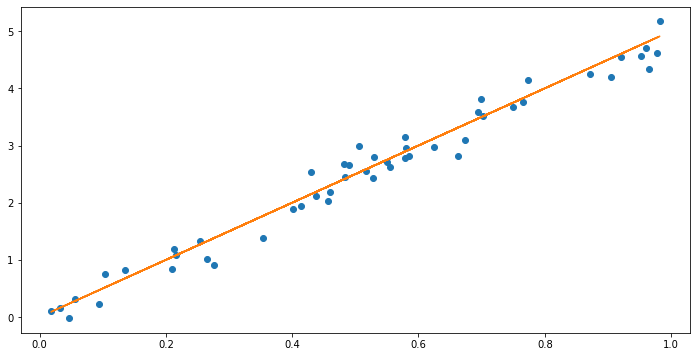

In [ ]:
plt.figure(1, figsize=(12,6))
plt.plot(X, y ,'o')
plt.plot(X, 5*X,'-')

In [ ]:
# Define model
model = BayesianLinearRegression(X, y, alpha, beta)

In [ ]:
# Fit MLE and MAP estimates for w
w_MLE = model.fit_MLE()
w_MAP, Lambda_inv = model.fit_MAP()

In [ ]:
print('MLE estimate: %f' % (w_MLE))
print('MAP estimate: %f' % (w_MAP))

MLE estimate: 4.914392
MAP estimate: 4.902851


In [ ]:
# Predict at a set of test points
X_star = np.linspace(0,1,200)[:,None]
y_pred_MLE = np.matmul(X_star, w_MLE)
y_pred_MAP = np.matmul(X_star, w_MAP)

In [ ]:
# Draw sampes from the predictive posterior
num_samples = 20
mean_star, var_star = model.predictive_distribution(X_star)
samples = np.random.multivariate_normal(mean_star.flatten(), var_star, (num_samples,))
percentiles = np.percentile(samples, [5.0, 95.0], axis=0)

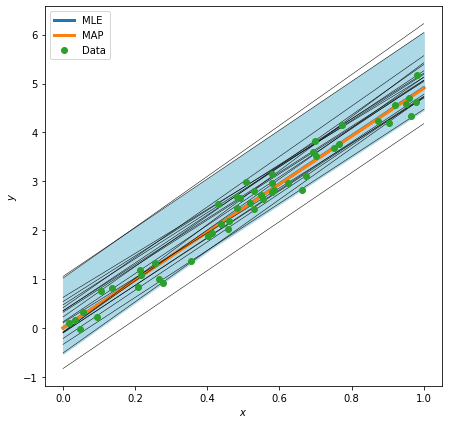

In [ ]:
# Plot
plt.figure(1, figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(X_star, y_pred_MLE, linewidth=3.0, label = 'MLE')
plt.plot(X_star, y_pred_MAP, linewidth=3.0, label = 'MAP')
for i in range(0, num_samples):
    plt.plot(X_star, samples[i,:], 'k', linewidth=0.5)
plt.fill_between(X_star.flatten(), percentiles[0, :], percentiles[1, :], color='lightblue')
plt.plot(X,y,'o', label = 'Data')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

Text(0, 0.5, '$p(w|D)$')

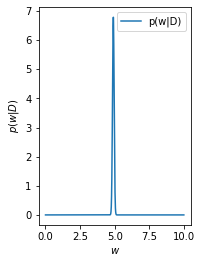

In [ ]:
# Plot distribution of w
plt.subplot(1,2,2)
x_axis = np.linspace(0, 10, 1000)[:,None]
plt.figure(1, figsize=(12,6))
plt.plot(x_axis, norm.pdf(x_axis,w_MAP,Lambda_inv), label = 'p(w|D)')
plt.legend()
plt.xlabel('$w$')
plt.ylabel('$p(w|D)$')